## 건설현장 이미지 프로젝트
 - 첫번째 프로젝트는 건설 현장에서 근로자들의 안전모 착용 여부를 확인하는 이미지 분류 모델 구현
  - 건설 현장의 사진을 분석하여 근로자들이 안전 기준을 준수하고 있는지 감지한다.


 - 두 번재 프로젝트는 건설 현장 이미지 세분화다.
   건설 현장의 복잡한 이미지를 분석하여 서로 다른 요소들을 구별한다.

 - 세 번쨰 프로젝트는 안전모 위치를 학습해서 영상 클립 상의 안전모 객체를 추적한다. 


In [4]:
#  코랩 한글 폰트 설치 - 설치후 런타임 재시작
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !wsl 로 시작 

['NanumGothic', 'NanumGothic', 'NanumGothic', 'NanumGothic']


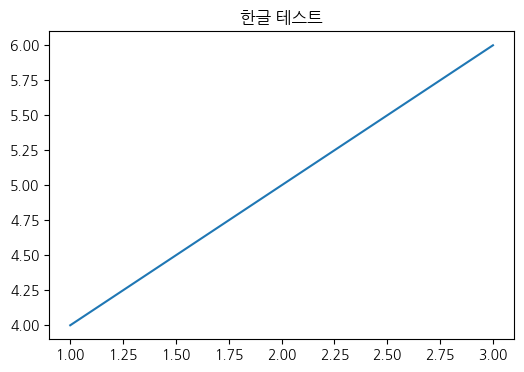

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import koreanize_matplotlib
# 한글 폰트 설정
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
# font.family : NanumGothic
# 폰트 적용 확인
print([f.name for f in fm.fontManager.ttflist if "Nanum" in f.name])

# 샘플 그래프 그리기
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("한글 테스트")
plt.show()

In [6]:
import os

img_dir = "./images"
xml_dir = "./annotations"

xml_files = [
    os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x.endswith(".xml")
]
xml_files[0]


'./annotations\\hard_hat_workers0.xml'

In [7]:
!wsl cat ./annotations/hard_hat_workers2743.xml

# xml 태그 내용 중에서 name 태그를 사용
# 객체 탐지를 위한 바운딩 박스는 사용하지 않고, 이미지 전체에서 헬멧의 착용 여부를 분류



<annotation>
    <folder>images</folder>
    <filename>hard_hat_workers2743.png</filename>
    <size>
        <width>416</width>
        <height>416</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>248</xmin>
            <ymin>91</ymin>
            <xmax>277</xmax>
            <ymax>125</ymax>
        </bndbox>
    </object>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>223</xmin>
            <ymin>113</ymin>
            <xmax>252</xmax>
            <ymax>158</ymax>
        </bndbox>
    </object>
    <object>
        <name>helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncate

In [8]:
# xml 파일에서 이미지 위치를 가져오기
import xml.etree.ElementTree as ET  # xml 파싱 모듈


def extract_info_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()  # 최상위 태그 선택(annoation)

    labels = []
    filename = root.find("filename").text
    for boxes in root.iter("object"):
        label = boxes.find("name").text  # name 태그 텍스트 추출
        if label == "head" or label == "person":
            return filename, 0

    return filename, 1


In [9]:
# 이미지와 레이블 분류 
import numpy as np 
import cv2
img_data = []
label_data = []

for xml_file in xml_files:
    filename, label = extract_info_from_xml(xml_file) # 넘어온 xml의 filename과 label 을 리턴 받음 
    
    # 이미지 파일 읽기 
    img_file = os.path.join(img_dir, filename) # 이미지 파일 저장 
    img = cv2.imread(img_file)
    
    label_data.append(label)
    resized_img = cv2.resize(img, (224,224))
    img_data.append(resized_img)
    
img_data = np.array(img_data)
label_data = np.array(label_data)

In [10]:
len(img_data), len(label_data)


(5000, 5000)

In [11]:
# 헬멧 착용 사진과 미착용 사진의 개수 확인
from collections import Counter

label_counter = Counter(label_data)
label_counter

# 헬멧 착용 1이 3940, 미착용 0이


Counter({1: 3940, 0: 1060})

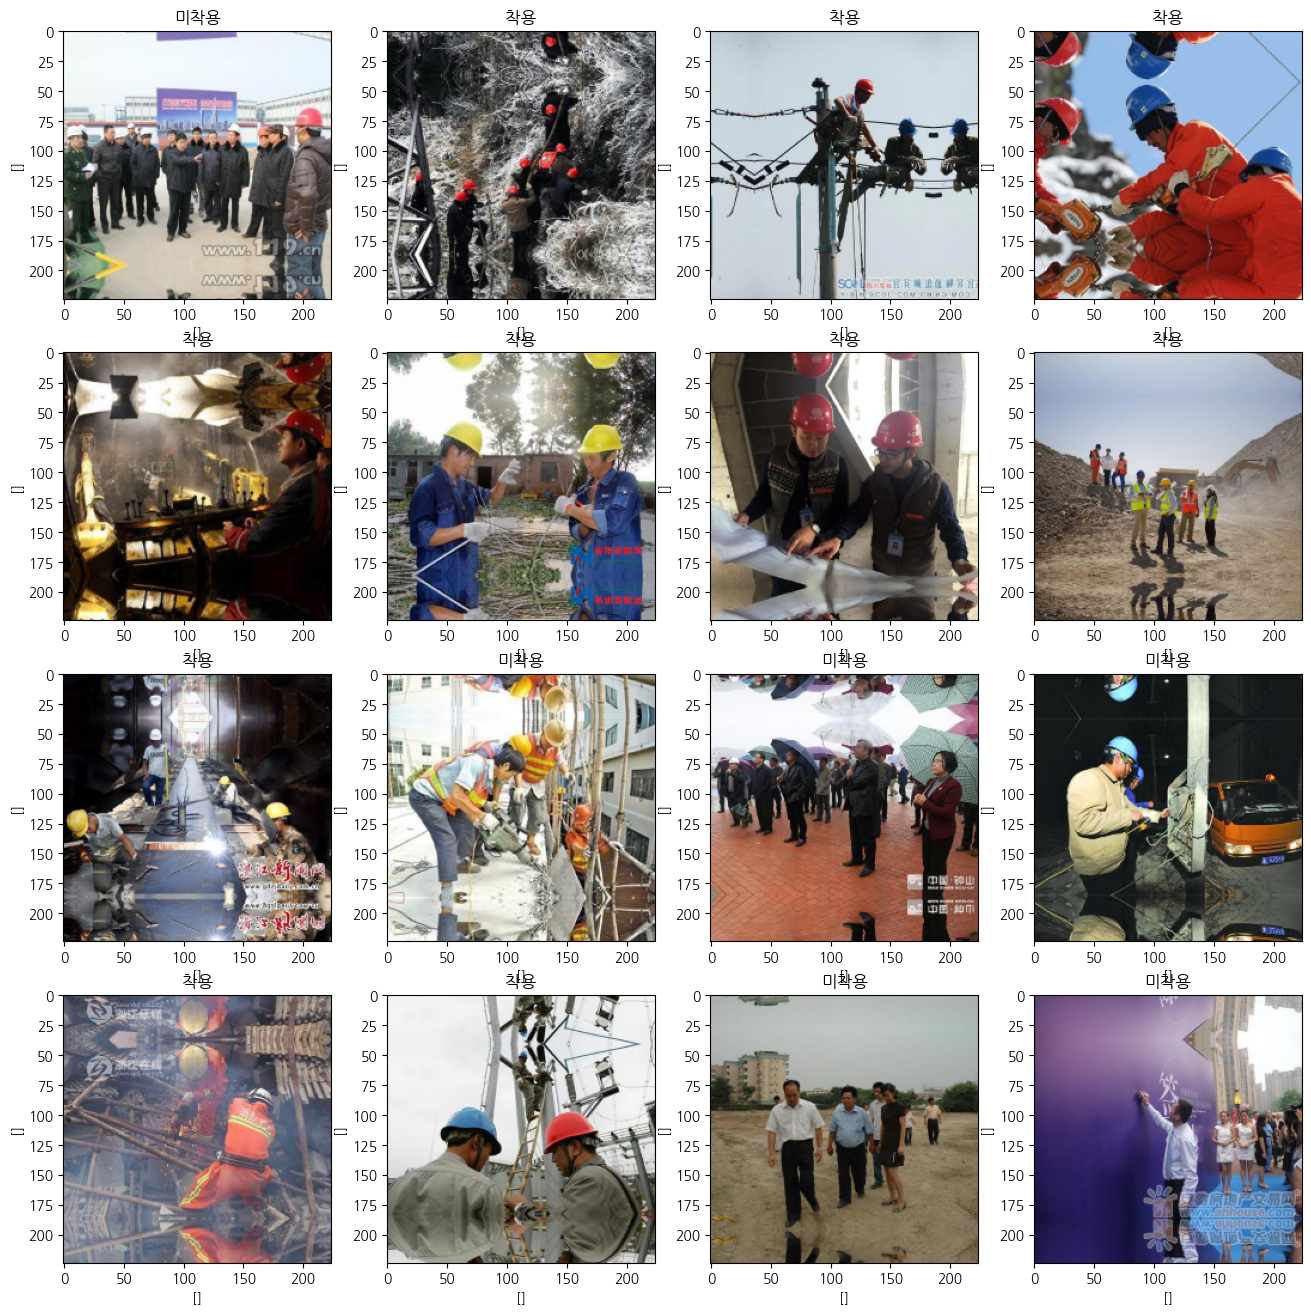

In [12]:
# 레이블링 이미지 시각화 

label_to_names = {0: '미착용', 1: '착용'}
plt.figure(figsize=(16,16))

for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(cv2.cvtColor(img_data[i], cv2.COLOR_BGR2RGB))
    label_name = label_to_names[label_data[i]]
    plt.xlabel([])
    plt.ylabel([])
    plt.title(label_name)
    
plt.show()

In [13]:
# 훈련 및 테스트 데이터 분리 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.1,stratify=label_data, random_state=42)

# 데이터 정규화 0~1 사이의 값 

X_train = X_train.astype('float32') / 255.0   # 값 줄이기 위해 float32 에 255 나누기 적용
X_test = X_test.astype("float32") / 255.0  # 원래 XML 데이터라서 uint8( 0~255  값임 

# 0255 ->   01 / 255.0 

print(X_train.shape, X_test.shape)


(4500, 224, 224, 3) (500, 224, 224, 3)


In [14]:
# 합성곱 신경망 훈련 모델 정의
# BatchNormalization: 과대 적합 방지를 위한 클래스
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
)

model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()


C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 220, 220, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 108, 108, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 106, 106, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 51, 51, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 49, 49, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 22, 22, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 512)         │       2,359,8

 Total params: 57,123,905 (217.91 MB)

 Trainable params: 57,120,065 (217.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

## Recall(재현율)


 - 실제로 양성(Positive)인 샘플 중에서 모델이 올바르게 예측한 비율을 의미
 - Recall = TP / TP + FN
  - TP: 올바르게 양성을 예측한 수
  - FN: 실제 양성이지만 음성으로 예측한 수
 - 질병 진단과 같이 양성 및 음성의 확률을 놓치지 않아야 할 때 주로 사용


## Precision(정밀도)


 - 모델이 양성(Positive)이라고 예측한 샘플 중 실제로 양성인 비율을 의미
 - Precision = TP / TP + FP
  - TP: 올바르게 양성으로 예측한 수
  - FP: 실제 음성이지만 양성으로 예측한 수
 - 정밀도가 높아 불필요한 광고 노출을 줄이는 것이 대표적인 용례


 # AUC(Area Under Curve, 곡선 아래 면적)


 - ROC 곡선(Receiver Operating Characteristic Curve) 아래 면적을 측정하는 지표로, 모델의 전체적인 분류 성능을 평가하는 데 사용
 - 0 ~ 1(1에 가까울수록 성능이 높음)
 - 금융 사기 탐지 등에서 수치가 높을 수록 정상 거래와 사기 거래를 잘 예측할 수 있음


In [15]:
from tensorflow.keras.metrics import Recall, Precision, AUC

# 모델 컴파일 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision'), AUC(name='auc')])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True, mode = 'max', verbose=1)

In [17]:
# # 모델 학습
# base_history = model.fit(
#     X_train,
#     y_train,
#     batch_size=32,
#     validation_split=0.2,
#     epochs=20,
#     callbacks=[model_checkpoint],
# )


In [18]:
from tensorflow.keras.models import load_model

# 모델 불러오기 
model = load_model('best_model.keras')

model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.8585 - auc: 0.8797 - loss: 0.3301 - precision: 0.8654 - recall: 0.9755


[0.3469341993331909,
 0.8659999966621399,
 0.9822335243225098,
 0.8657718300819397,
 0.8891509771347046]

16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step


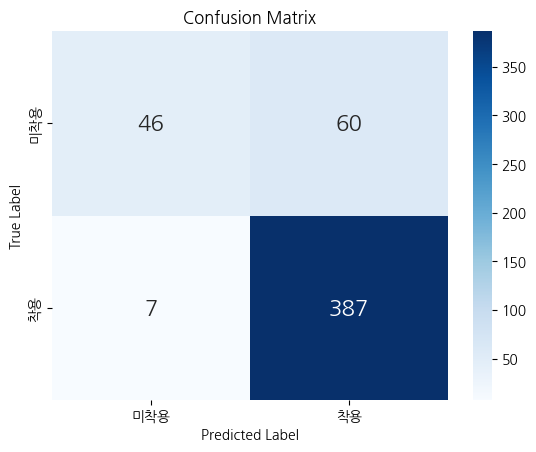

In [21]:
# 혼돈 행렬 작성 
predicted_prob = model.predict(X_test)

# 확률 값을 0.5 임계값 기준으로 정의 
threshold = 0.5 

# 확률 값을 예측 레이블 (0,1) 로 변경 
y_pred = (predicted_prob > threshold).astype(int)

import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# 시각화 

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size':16},xticklabels=['미착용','착용'], yticklabels=['미착용', '착용'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_image_path = "doge.jpg"


# 이미지 전처리 함수
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    return img


# 이미지 예측 함수
def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_lable = "착용" if prediction[0] > 0.5 else "미착용"

    print(f"예측 결과: {predicted_lable} - 확률: {prediction[0][0]: .3f}")


# 테스트 실행
predict_image(test_image_path)
